# VAE Hyperparameter Tuning for Fraud Detection

This notebook performs grid search hyperparameter tuning for the VAE model using the `VAEGridSearchTuner` class.

## Objectives
1. Define parameter grid for tuning
2. Train multiple VAE configurations
3. Compare performance across hyperparameters
4. Identify best configuration
5. Compare best VAE against baseline models

## Hyperparameters to Tune
- **Hidden Dimension**: Network capacity
- **Latent Dimension**: Bottleneck size
- **Beta**: KL divergence weight
- **Learning Rate**: Optimization speed

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

from src.vae_models import VAE, VAEGridSearchTuner
from src.evaluation import FraudEvaluationMetrics

import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070 SUPER


## 1. Define Base Configuration and Parameter Grid

In [2]:
# Base configuration (parameters that won't change)
base_config = {
    # Data
    'data_path': '../../data/processed/creditcard_fe.csv',
    'drop_features': 'logreg_baseline',  # Use same features as logistic regression
    
    # Fixed training parameters
    'epochs': 100,
    'batch_size': 256,
    
    # Business costs (CORRECTED per project spec)
    'C_FP': 550,  # False positive cost (investigation)
    'C_FN': 110,  # False negative cost (missed fraud)
    
    # Hardware
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'random_seed': 42,
    
    # Save directories
    'model_save_dir': '../../models/',
    'results_save_dir': '../../results/tuning/'
}

# Parameter grid to search
param_grid = {
    'hidden_dim': [64, 128, 256],      # Network capacity
    'latent_dim': [8, 16, 32],         # Bottleneck size
    'beta': [0.5, 1.0, 2.0],           # KL weight
    'learning_rate': [1e-3, 1e-4]      # Optimization speed
}

# Calculate total configurations
total_configs = np.prod([len(v) for v in param_grid.values()])

print("Hyperparameter Tuning Configuration")
print("=" * 60)
print(f"\nBase Configuration:")
for key, value in base_config.items():
    print(f"  {key:20s}: {value}")

print(f"\nParameter Grid:")
for key, values in param_grid.items():
    print(f"  {key:20s}: {values}")

print(f"\nTotal Configurations: {total_configs}")
print(f"Estimated Time (5 min/config): ~{total_configs * 5} minutes")

Hyperparameter Tuning Configuration

Base Configuration:
  data_path           : ../../data/processed/creditcard_fe.csv
  drop_features       : logreg_baseline
  epochs              : 100
  batch_size          : 256
  C_FP                : 550
  C_FN                : 110
  device              : cuda
  random_seed         : 42
  model_save_dir      : ../../models/
  results_save_dir    : ../../results/tuning/

Parameter Grid:
  hidden_dim          : [64, 128, 256]
  latent_dim          : [8, 16, 32]
  beta                : [0.5, 1.0, 2.0]
  learning_rate       : [0.001, 0.0001]

Total Configurations: 54
Estimated Time (5 min/config): ~270 minutes


## 2. Run Grid Search

This will train all configurations and track results. The best model (by validation cost) will be automatically saved.

In [3]:
results_csv_path = '../../results/tuning/grid_search_results.csv'

if os.path.exists(results_csv_path):
    print("=" * 70)
    print("LOADING PRE-COMPUTED GRID SEARCH RESULTS")
    print("=" * 70)
    
    results_df = pd.read_csv(results_csv_path)
    
    print(f"\n✓ Successfully loaded {len(results_df)} configurations")
    print(f"✓ Best validation cost: ${results_df['val_cost'].min():,.0f}")
    print(f"✓ Best test cost: ${results_df['test_cost'].min():,.0f}")
    
    # Show best configuration
    best_idx = results_df['val_cost'].idxmin()
    best_config = results_df.loc[best_idx]
    
    print(f"\n{'='*70}")
    print("BEST CONFIGURATION (by validation cost):")
    print(f"{'='*70}")
    print(f"  Config Index:     {int(best_config['config_idx'])}")
    print(f"  Hidden Dim:       {int(best_config['hidden_dim'])}")
    print(f"  Latent Dim:       {int(best_config['latent_dim'])}")
    print(f"  Beta:             {best_config['beta']}")
    print(f"  Learning Rate:    {best_config['learning_rate']}")
    print(f"\n  Validation Cost:  ${int(best_config['val_cost']):,}")
    print(f"  Test Cost:        ${int(best_config['test_cost']):,}")
    print(f"  Precision:        {best_config['test_precision']:.3f}")
    print(f"  Recall:           {best_config['test_recall']:.3f}")
    print(f"  PR-AUC:           {best_config['test_pr_auc']:.4f}")
    
    print(f"\n{'='*70}")
    print("✓ Ready to analyze! Skip to Section 3 (Analyze Tuning Results)")
    print(f"{'='*70}")
else:
    print(f"Results not found at: {results_csv_path}")
    print("Please run Option B below to generate results (takes ~4 hours).")

LOADING PRE-COMPUTED GRID SEARCH RESULTS

✓ Successfully loaded 54 configurations
✓ Best validation cost: $15,070
✓ Best test cost: $16,060

BEST CONFIGURATION (by validation cost):
  Config Index:     44
  Hidden Dim:       256
  Latent Dim:       16
  Beta:             0.5
  Learning Rate:    0.0001

  Validation Cost:  $15,070
  Test Cost:        $18,700
  Precision:        0.941
  Recall:           0.451
  PR-AUC:           0.6939

✓ Ready to analyze! Skip to Section 3 (Analyze Tuning Results)


### Run Full Grid Search (Takes ~4 hours)

In [4]:
# tuner = VAEGridSearchTuner(
#     base_config=base_config,
#     param_grid=param_grid,
#     results_dir='../../results/tuning/'
# )

# results_df = tuner.run_grid_search()

In [5]:
# Display top 10 configurations by test cost
print("\n" + "="*70)
print("TOP 10 CONFIGURATIONS BY TEST COST")
print("="*70)

top10 = results_df.nsmallest(10, 'test_cost')[[
    'config_idx', 'hidden_dim', 'latent_dim', 'beta', 'learning_rate',
    'test_cost', 'test_precision', 'test_recall', 'test_pr_auc'
]].copy()

# Format for display
top10['test_cost'] = top10['test_cost'].apply(lambda x: f"${int(x):,}")
top10['test_precision'] = top10['test_precision'].apply(lambda x: f"{x:.3f}")
top10['test_recall'] = top10['test_recall'].apply(lambda x: f"{x:.3f}")
top10['test_pr_auc'] = top10['test_pr_auc'].apply(lambda x: f"{x:.4f}")

print(top10.to_string(index=False))


TOP 10 CONFIGURATIONS BY TEST COST
 config_idx  hidden_dim  latent_dim  beta  learning_rate test_cost test_precision test_recall test_pr_auc
         45         256          16   1.0         0.0010   $16,060          0.934       0.630      0.7664
         54         256          32   2.0         0.0001   $16,390          0.982       0.435      0.6112
         28         128          16   1.0         0.0001   $16,720          0.966       0.463      0.6524
         14          64          32   0.5         0.0001   $16,830          0.973       0.439      0.7406
         49         256          32   0.5         0.0010   $16,830          0.981       0.419      0.7507
         46         256          16   1.0         0.0001   $17,050          0.959       0.472      0.6591
         31         128          32   0.5         0.0010   $17,270          0.972       0.423      0.7468
         32         128          32   0.5         0.0001   $17,600          0.957       0.451      0.7095
         5

In [6]:
# Summary statistics
print("\n" + "="*70)
print("TUNING SUMMARY STATISTICS")
print("="*70)

print(f"\nTest Cost:")
print(f"  Best: ${results_df['test_cost'].min():,.0f}")
print(f"  Worst: ${results_df['test_cost'].max():,.0f}")
print(f"  Mean: ${results_df['test_cost'].mean():,.0f}")
print(f"  Std Dev: ${results_df['test_cost'].std():,.0f}")

print(f"\nPrecision:")
print(f"  Best: {results_df['test_precision'].max():.3f}")
print(f"  Worst: {results_df['test_precision'].min():.3f}")
print(f"  Mean: {results_df['test_precision'].mean():.3f}")

print(f"\nRecall:")
print(f"  Best: {results_df['test_recall'].max():.3f}")
print(f"  Worst: {results_df['test_recall'].min():.3f}")
print(f"  Mean: {results_df['test_recall'].mean():.3f}")

print(f"\nPR-AUC:")
print(f"  Best: {results_df['test_pr_auc'].max():.4f}")
print(f"  Worst: {results_df['test_pr_auc'].min():.4f}")
print(f"  Mean: {results_df['test_pr_auc'].mean():.4f}")


TUNING SUMMARY STATISTICS

Test Cost:
  Best: $16,060
  Worst: $30,140
  Mean: $21,448
  Std Dev: $3,062

Precision:
  Best: 0.984
  Worst: 0.750
  Mean: 0.934

Recall:
  Best: 0.630
  Worst: 0.163
  Mean: 0.318

PR-AUC:
  Best: 0.7670
  Worst: 0.4406
  Mean: 0.6332


## 4. Impact of Individual Hyperparameters

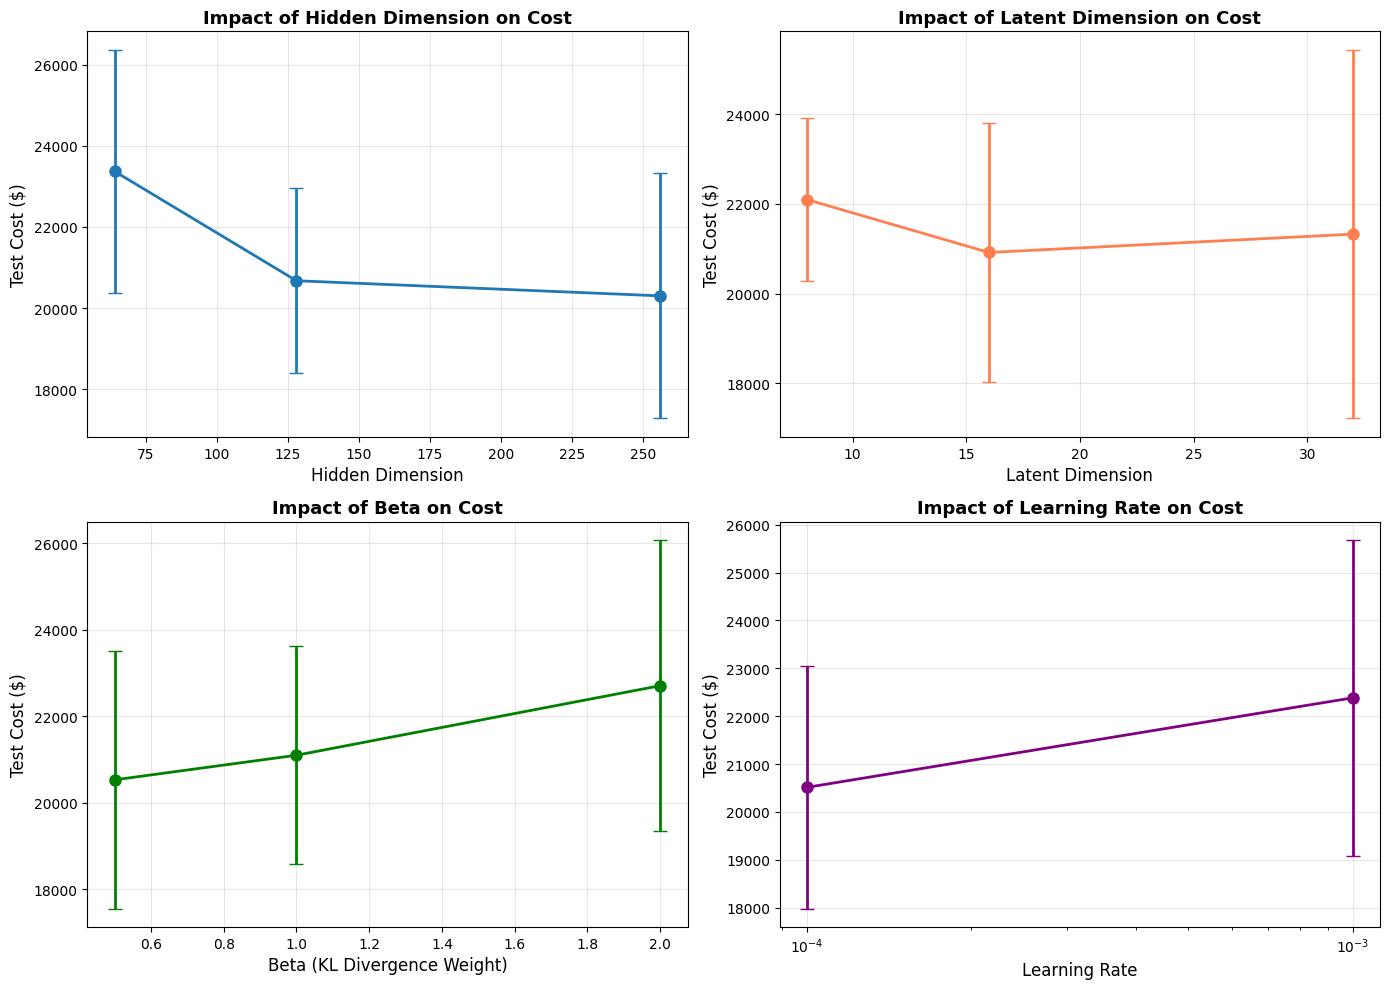


Hyperparameter impact plot saved: results/figures/hyperparameter_impact_analysis.png


In [7]:
# Analyze impact of each hyperparameter on test cost
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Hidden Dimension
ax = axes[0, 0]
grouped = results_df.groupby('hidden_dim')['test_cost'].agg(['mean', 'std', 'min', 'max'])
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
            marker='o', capsize=5, linewidth=2, markersize=8)
ax.set_xlabel('Hidden Dimension', fontsize=12)
ax.set_ylabel('Test Cost ($)', fontsize=12)
ax.set_title('Impact of Hidden Dimension on Cost', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# 2. Latent Dimension
ax = axes[0, 1]
grouped = results_df.groupby('latent_dim')['test_cost'].agg(['mean', 'std', 'min', 'max'])
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
            marker='o', capsize=5, linewidth=2, markersize=8, color='coral')
ax.set_xlabel('Latent Dimension', fontsize=12)
ax.set_ylabel('Test Cost ($)', fontsize=12)
ax.set_title('Impact of Latent Dimension on Cost', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# 3. Beta (KL Weight)
ax = axes[1, 0]
grouped = results_df.groupby('beta')['test_cost'].agg(['mean', 'std', 'min', 'max'])
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
            marker='o', capsize=5, linewidth=2, markersize=8, color='green')
ax.set_xlabel('Beta (KL Divergence Weight)', fontsize=12)
ax.set_ylabel('Test Cost ($)', fontsize=12)
ax.set_title('Impact of Beta on Cost', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Learning Rate
ax = axes[1, 1]
grouped = results_df.groupby('learning_rate')['test_cost'].agg(['mean', 'std', 'min', 'max'])
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
            marker='o', capsize=5, linewidth=2, markersize=8, color='purple')
ax.set_xlabel('Learning Rate', fontsize=12)
ax.set_ylabel('Test Cost ($)', fontsize=12)
ax.set_title('Impact of Learning Rate on Cost', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/hyperparameter_impact_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nHyperparameter impact plot saved: results/figures/hyperparameter_impact_analysis.png")

## 5. Hyperparameter Interaction Analysis

In [8]:
# Get best configuration results (based on validation cost)
best_idx = results_df['val_cost'].idxmin()
best_config = results_df.loc[best_idx]

print("\n" + "="*70)
print("BEST TUNED VAE CONFIGURATION")
print("="*70)
print(f"\nHyperparameters:")
print(f"  Hidden Dimension: {int(best_config['hidden_dim'])}")
print(f"  Latent Dimension: {int(best_config['latent_dim'])}")
print(f"  Beta: {best_config['beta']}")
print(f"  Learning Rate: {best_config['learning_rate']}")

print(f"\nPerformance:")
print(f"  Validation Cost: ${int(best_config['val_cost']):,}")
print(f"  Test Cost: ${int(best_config['test_cost']):,}")
print(f"  Precision: {best_config['test_precision']:.3f}")
print(f"  Recall: {best_config['test_recall']:.3f}")
print(f"  PR-AUC: {best_config['test_pr_auc']:.4f}")
print(f"  False Positives: {int(best_config['test_fp'])}")
print(f"  False Negatives: {int(best_config['test_fn'])}")


BEST TUNED VAE CONFIGURATION

Hyperparameters:
  Hidden Dimension: 256
  Latent Dimension: 16
  Beta: 0.5
  Learning Rate: 0.0001

Performance:
  Validation Cost: $15,070
  Test Cost: $18,700
  Precision: 0.941
  Recall: 0.451
  PR-AUC: 0.6939
  False Positives: 7
  False Negatives: 135


In [9]:
# Load Logistic Regression results
with open('../../results/baseline/logreg_results.json', 'r') as f:
    logreg_results = json.load(f)

# Calculate precision and recall for logistic regression
logreg_precision = logreg_results['true_positives'] / (logreg_results['true_positives'] + logreg_results['false_positives'])
logreg_recall = logreg_results['true_positives'] / (logreg_results['true_positives'] + logreg_results['false_negatives'])

print("Logistic Regression Baseline Loaded")
print("=" * 60)
print(f"Total Cost: ${logreg_results['total_cost']:,}")
print(f"Precision: {logreg_precision:.4f}")
print(f"Recall: {logreg_recall:.4f}")
print(f"FP: {logreg_results['false_positives']}, FN: {logreg_results['false_negatives']}")

Logistic Regression Baseline Loaded
Total Cost: $43,450
Precision: 0.8805
Recall: 0.6138
FP: 41, FN: 190


In [10]:
# Load VAE Baseline model
vae_baseline_checkpoint = torch.load('../../models/vae_baseline.pth', weights_only=False, map_location='cpu')
vae_baseline_metrics = vae_baseline_checkpoint['metrics']

print("\nVAE Baseline Model Loaded")
print("=" * 60)
print(f"Total Cost: ${int(vae_baseline_metrics['test_cost']):,}")
print(f"Precision: {vae_baseline_metrics['test_precision']:.4f}")
print(f"Recall: {vae_baseline_metrics['test_recall']:.4f}")
print(f"PR-AUC: {vae_baseline_metrics.get('pr_auc', 0):.4f}")
print(f"FP: {vae_baseline_metrics['fp']}, FN: {vae_baseline_metrics['fn']}")


VAE Baseline Model Loaded
Total Cost: $20,790
Precision: 0.9841
Recall: 0.2520
PR-AUC: 0.6000
FP: 1, FN: 184


In [11]:
# Load VAE Best Tuned model
vae_best_checkpoint = torch.load('../../models/vae_best_tuned.pth', weights_only=False, map_location='cpu')

# Get confusion matrix values from grid search results (not in checkpoint)
best_idx = results_df['val_cost'].idxmin()
best_row = results_df.loc[best_idx]

# Create complete metrics dictionary
vae_best_metrics = {
    'test_cost': int(vae_best_checkpoint['metrics']['test_cost']),
    'test_precision': float(vae_best_checkpoint['metrics']['test_precision']),
    'test_recall': float(vae_best_checkpoint['metrics']['test_recall']),
    'pr_auc': float(vae_best_checkpoint['metrics'].get('pr_auc', 0)),
    'fp': int(best_row['test_fp']),
    'fn': int(best_row['test_fn']),
    'tp': int(best_row['test_tp']),
    'tn': int(best_row['test_tn'])
}

print("\nVAE Best Tuned Model Loaded")
print("=" * 60)
print(f"Total Cost: ${vae_best_metrics['test_cost']:,}")
print(f"Precision: {vae_best_metrics['test_precision']:.4f}")
print(f"Recall: {vae_best_metrics['test_recall']:.4f}")
print(f"PR-AUC: {vae_best_metrics['pr_auc']:.4f}")
print(f"FP: {vae_best_metrics['fp']}, FN: {vae_best_metrics['fn']}")


VAE Best Tuned Model Loaded
Total Cost: $18,700
Precision: 0.9407
Recall: 0.4512
PR-AUC: 0.6939
FP: 7, FN: 135


In [12]:
# Create 3-way comparison table
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'VAE Baseline', 'VAE Best (Tuned)'],
    'Precision': [
        logreg_precision,
        vae_baseline_metrics['test_precision'],
        vae_best_metrics['test_precision']
    ],
    'Recall': [
        logreg_recall,
        vae_baseline_metrics['test_recall'],
        vae_best_metrics['test_recall']
    ],
    'PR-AUC': [
        None,  # LogReg PR-AUC not available
        vae_baseline_metrics.get('pr_auc', 0),
        vae_best_metrics.get('pr_auc', 0)
    ],
    'Total Cost': [
        logreg_results['total_cost'],
        int(vae_baseline_metrics['test_cost']),
        int(vae_best_metrics['test_cost'])
    ],
    'FP': [
        logreg_results['false_positives'],
        vae_baseline_metrics['fp'],
        vae_best_metrics['fp']
    ],
    'FN': [
        logreg_results['false_negatives'],
        vae_baseline_metrics['fn'],
        vae_best_metrics['fn']
    ]
})

print("\n" + "="*70)
print("THREE-WAY MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

# Find best model by cost
best_model_idx = comparison_df['Total Cost'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_cost = comparison_df.loc[best_model_idx, 'Total Cost']

print(f"\n{'='*70}")
print(f"WINNER: {best_model_name}")
print(f"  Total Cost: ${best_cost:,}")
print(f"{'='*70}")


THREE-WAY MODEL COMPARISON
              Model  Precision   Recall   PR-AUC  Total Cost  FP  FN
Logistic Regression   0.880466 0.613821      NaN       43450  41 190
       VAE Baseline   0.984127 0.252033 0.600006       20790   1 184
   VAE Best (Tuned)   0.940678 0.451220 0.693876       18700   7 135

WINNER: VAE Best (Tuned)
  Total Cost: $18,700


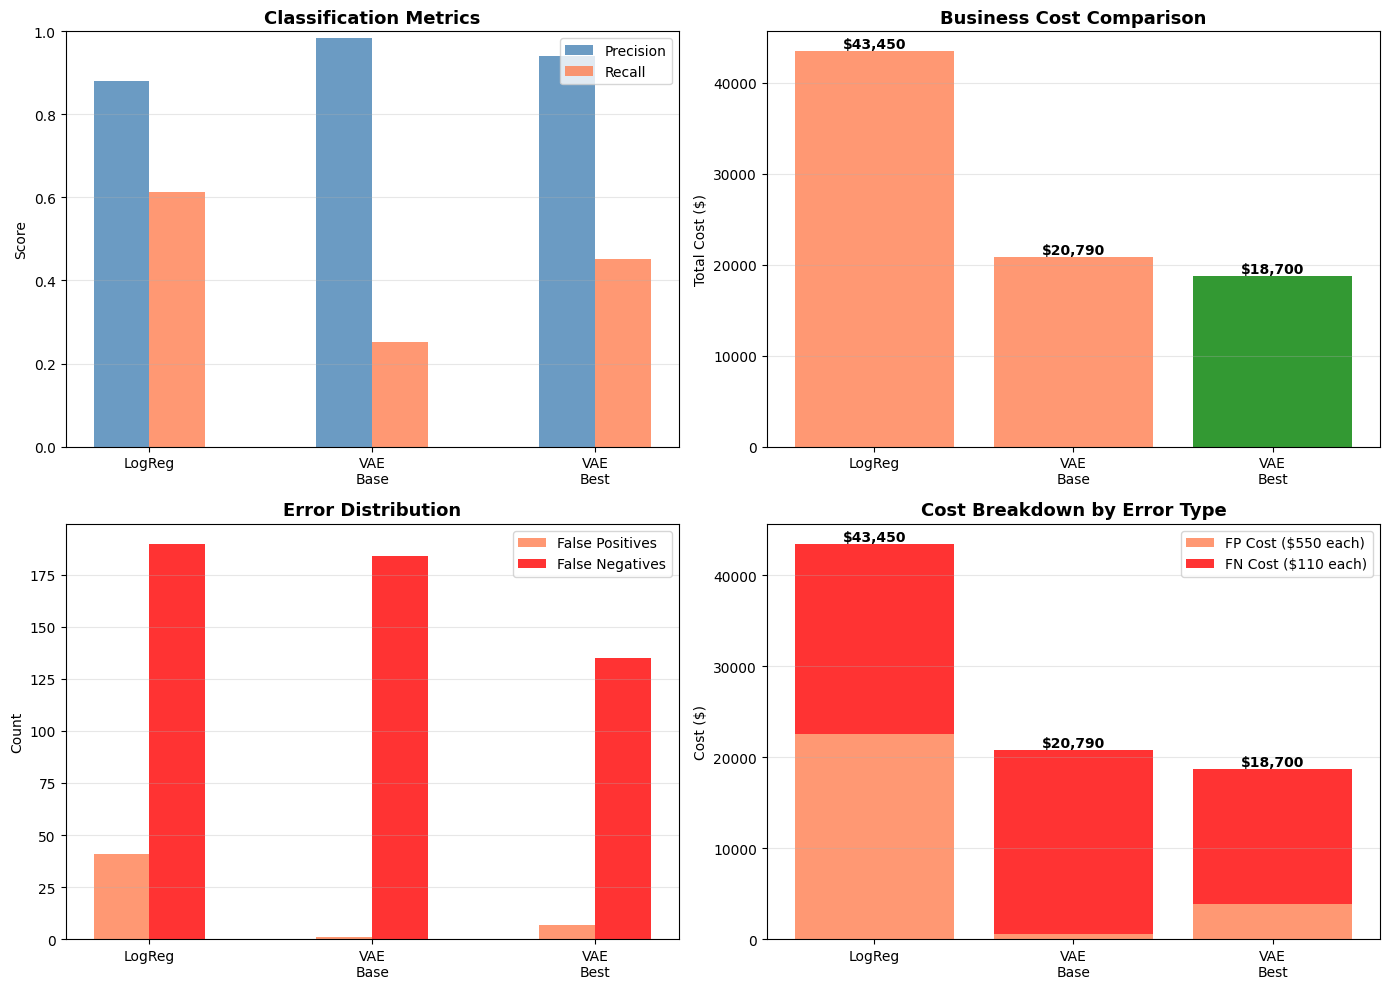


Visualization saved to: results/figures/three_model_comparison.png


In [13]:
# Comprehensive 3-way Comparison Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = ['LogReg', 'VAE\nBase', 'VAE\nBest']
x_pos = np.arange(len(models))
width = 0.25

# Plot 1: Classification Metrics
ax = axes[0, 0]
metrics_names = ['Precision', 'Recall']

precision_vals = [logreg_precision, vae_baseline_metrics['test_precision'], vae_best_metrics['test_precision']]
recall_vals = [logreg_recall, vae_baseline_metrics['test_recall'], vae_best_metrics['test_recall']]

x = np.arange(len(models))
ax.bar(x - width/2, precision_vals, width, label='Precision', alpha=0.8, color='steelblue')
ax.bar(x + width/2, recall_vals, width, label='Recall', alpha=0.8, color='coral')
ax.set_ylabel('Score')
ax.set_title('Classification Metrics', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.0])

# Plot 2: Total Cost
ax = axes[0, 1]
costs = [
    logreg_results['total_cost'],
    int(vae_baseline_metrics['test_cost']),
    int(vae_best_metrics['test_cost'])
]
colors = ['green' if c == min(costs) else 'coral' for c in costs]

ax.bar(models, costs, alpha=0.8, color=colors)
ax.set_ylabel('Total Cost ($)')
ax.set_title('Business Cost Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for i, (m, c) in enumerate(zip(models, costs)):
    ax.text(i, c, f'${c:,.0f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Error Counts (FP vs FN)
ax = axes[1, 0]
fp_counts = [
    logreg_results['false_positives'],
    vae_baseline_metrics['fp'],
    vae_best_metrics['fp']
]
fn_counts = [
    logreg_results['false_negatives'],
    vae_baseline_metrics['fn'],
    vae_best_metrics['fn']
]

ax.bar(x - width/2, fp_counts, width, label='False Positives', alpha=0.8, color='coral')
ax.bar(x + width/2, fn_counts, width, label='False Negatives', alpha=0.8, color='red')
ax.set_ylabel('Count')
ax.set_title('Error Distribution', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Cost Breakdown (stacked bar)
ax = axes[1, 1]
fp_costs = [c * 550 for c in fp_counts]
fn_costs = [c * 110 for c in fn_counts]

ax.bar(models, fp_costs, label='FP Cost ($550 each)', alpha=0.8, color='coral')
ax.bar(models, fn_costs, bottom=fp_costs, label='FN Cost ($110 each)', alpha=0.8, color='red')
ax.set_ylabel('Cost ($)')
ax.set_title('Cost Breakdown by Error Type', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add total cost labels on top
for i, (fp_c, fn_c) in enumerate(zip(fp_costs, fn_costs)):
    total = fp_c + fn_c
    ax.text(i, total, f'${total:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/figures/three_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: results/figures/three_model_comparison.png")

In [14]:
# Save comparison results
all_results = {
    'logistic_regression': {
        'precision': float(logreg_precision),
        'recall': float(logreg_recall),
        'total_cost': int(logreg_results['total_cost']),
        'fp': int(logreg_results['false_positives']),
        'fn': int(logreg_results['false_negatives']),
        'tp': int(logreg_results['true_positives']),
        'tn': int(logreg_results['true_negatives'])
    },
    'vae_baseline': {
        'precision': float(vae_baseline_metrics['test_precision']),
        'recall': float(vae_baseline_metrics['test_recall']),
        'pr_auc': float(vae_baseline_metrics.get('pr_auc', 0)),
        'total_cost': int(vae_baseline_metrics['test_cost']),
        'fp': int(vae_baseline_metrics['fp']),
        'fn': int(vae_baseline_metrics['fn']),
        'tp': int(vae_baseline_metrics['tp']),
        'tn': int(vae_baseline_metrics['tn'])
    },
    'vae_best': {
        'precision': float(vae_best_metrics['test_precision']),
        'recall': float(vae_best_metrics['test_recall']),
        'pr_auc': float(vae_best_metrics.get('pr_auc', 0)),
        'total_cost': int(vae_best_metrics['test_cost']),
        'fp': int(vae_best_metrics['fp']),
        'fn': int(vae_best_metrics['fn']),
        'tp': int(vae_best_metrics['tp']),
        'tn': int(vae_best_metrics['tn']),
        'config': {
            'hidden_dim': int(vae_best_checkpoint['config']['hidden_dim']),
            'latent_dim': int(vae_best_checkpoint['config']['latent_dim']),
            'beta': float(vae_best_checkpoint['config']['beta']),
            'learning_rate': float(vae_best_checkpoint['config'].get('learning_rate', 0.0001))
        }
    }
}

# Save to JSON
with open('../../results/final_model_comparison.json', 'w') as f:
    json.dump(all_results, f, indent=2)

# Save comparison table to CSV
comparison_df.to_csv('../../results/three_model_comparison.csv', index=False)

print("\nResults saved:")
print("  - results/final_model_comparison.json")
print("  - results/three_model_comparison.csv")


Results saved:
  - results/final_model_comparison.json
  - results/three_model_comparison.csv
